In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import simps

# Lendo arquivo das waveforms

#### O arquivo original já foi parcialmente modificado em relação a linhas e colunas

In [2]:
'''Lendo arquivo das waveforms'''

waveform = pd.read_csv(
    '5555_eventos-edit.csv', 
    index_col = 0
                      ) # importa como waveform vs sample
waveform

,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,...,event_5546,event_5547,event_5548,event_5549,event_5550,event_5551,event_5552,event_5553,event_5554,time
0,56.0,56.0,56.0,53.0,55.0,55.0,54.0,54.0,54.0,54.0,...,54.0,53.0,53.0,51.0,51.0,51.0,51.0,51.0,51.0,0
1,55.0,55.0,55.0,53.0,55.0,55.0,54.0,54.0,54.0,54.0,...,52.0,52.0,52.0,52.0,51.0,51.0,51.0,51.0,51.0,1
2,53.0,53.0,53.0,51.0,53.0,53.0,55.0,55.0,55.0,55.0,...,53.0,53.0,53.0,50.0,55.0,55.0,55.0,55.0,55.0,2
3,53.0,53.0,53.0,52.0,53.0,53.0,54.0,54.0,54.0,54.0,...,53.0,53.0,53.0,50.0,55.0,55.0,55.0,55.0,55.0,3
4,54.0,54.0,54.0,53.0,55.0,55.0,55.0,55.0,55.0,55.0,...,51.0,53.0,53.0,52.0,54.0,54.0,54.0,54.0,54.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,53.0,53.0,53.0,54.0,55.0,55.0,22.0,22.0,22.0,22.0,...,54.0,50.0,50.0,50.0,52.0,52.0,52.0,52.0,52.0,2495
2496,55.0,55.0,55.0,54.0,56.0,56.0,14.0,14.0,14.0,14.0,...,50.0,51.0,51.0,53.0,51.0,51.0,51.0,51.0,51.0,2496
2497,52.0,52.0,52.0,53.0,53.0,53.0,37.0,37.0,37.0,37.0,...,53.0,51.0,51.0,53.0,52.0,52.0,52.0,52.0,52.0,2497
2498,52.0,52.0,52.0,53.0,54.0,54.0,51.0,51.0,51.0,51.0,...,52.0,53.0,53.0,52.0,52.0,52.0,52.0,52.0,52.0,2498


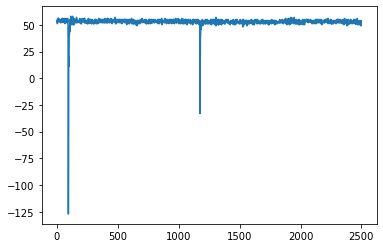

In [15]:
plt.plot( waveform.time, waveform.event_70 )

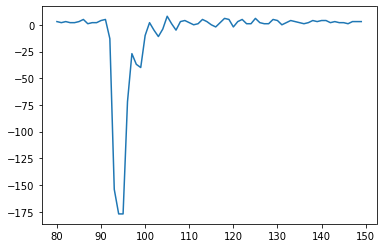

In [33]:
a, b = 80 , 150
plt.plot( df.time.iloc[a:b] , df.event_796.iloc[a:b] )

# Construindo os métodos para a análise de dados

#### 1. Peak_finder 

Auxilia a encontrar todos os picos de uma waveform. No caso, encontra dois picos.

In [3]:
def peak_finder(_s, height): # peak_finder se aplica em data frames com valores dp eixo y
    _s *= -1 # CUIDADO: aparentemente, isso muda o df. Tenha certeza que irá desfazer isso depois
    
    # get the actual peaks
    peaks, _ = find_peaks(_s, height = 40) # height é um parâmetro decidido
    
    # print(peaks)
    
    # multiply back for plotting purposes
    _s *= -1
    
    
    return(peaks)

#### 2. delta_signal

Encontra as diferenças entre elementos lado-a-lado. Serve para avaliar quando estamos começando ou terminando um pulso.

In [24]:
def delta_signal(y_values): # esta função retorna os valores no eixo x; aplicado em elementos de 1D
    
    VA_baseLine = 5 # valor "aleatório" para saber se o número em questão está fora da base-line
    
    delta = [ 
        i for i in range( len(y_values) - 1 ) 
           if ( abs(y_values[i] - y_values[i+1]) > VA_baseLine) 
            ] # é interessante calcular com base no módulo
    return(delta)

#### 3. contorno_pulso

Encontra os valores dos dois pulsos em cada uma das waveforms. Utiliza as duas funções anteriores. 
Funciona da seguinte maneira: encontra os picos e delimita os entornos. Daí, guarda os pontos interiores do pulso e os devolve.

In [19]:
def contorno_pulso(_s): # recebe uma Series do pandas para começar
    
    '''
    encontra os picos e os valores (em x) máximo e mínimo do pulso 
    '''
    
    VA_1 = 20
    VA_2 = 50
    
    peak = peak_finder(_s, height = 50)
    
    slicing =  _s[  (peak[0] - VA_1):(peak[1] + VA_2)  ]
    
    _evento          = pd.DataFrame( delta_signal(_s) )
    _evento.columns  = ['coluna'] # nome genérico, para ser chamável depois 
    
    
    
    '''
    determina a largura de cada pulso no eixo x
    '''
    
    largura_max_esperada = 100 # define a abertura de uma janela para procurar o pulso ali dentro
    
    lista = []
    for i in range(2):
        
        s = _evento.query( 
            '(coluna > @peak[@i] - @largura_max_esperada/2) and (coluna < @peak[@i] + @largura_max_esperada/2)'
                        )['coluna']
        # este objeto é uma Series
        
        lista.append( s.min() )
        lista.append( s.max() ) # transformar em lista serve para facilitar o plot gráfico    

            
              
    '''
    cria o data frame com os contornos máximo e mínimo do pulso em x e y
    '''
    
    df = pd.DataFrame(_s)
    df.columns = ['coluna'] # nome genérico, para ser chamável depois
    
    limites_largura_pulsos = pd.DataFrame( df.query('@lista')['coluna'] ).reset_index() 
    # este método anterior acaba por mover os valores do index para uma coluna e resetar o index principal
    # daí, é só renomear o index e as colunas
            
    limites_largura_pulsos.index   = ['min_1', 'max_1', 'min_2', 'max_2']
    limites_largura_pulsos.columns = ['pulso_x', 'pulso_y']


    '''
    remodela o data frame com os valores em x e y para cada um dos primeiros pulsos
    '''
    
    _aux = []
    for i in range(0,3,2): # é um loop para atuar apenas duas vezes: 0,1 e 2,3
        s = df.query(" index >= @lista[@i] and index <= @lista[@i+1] ")['coluna']
        _aux.append(s)
        
    pulsos = pd.concat(_aux, axis = 1).reset_index() # coordenada x, primeiro pulso, segundo pulso
    pulsos.columns = ['time', 'pulso_1', 'pulso_2']
    
    
    
    
    return(pulsos)

#### integral_pulso

Calcula a integral do contorno do pulso da waveform utilizando a integração numérica de Simpson.

In [20]:
def integral_pulso(_df): # df = ['time', 'pulso_1', 'pulso_2']
    
    _aux = []
    for i in (1,2):
        integral = simps(    _df[ _df.columns[i] ].dropna(),    dx = 1     )
        _aux.append(integral)
    
    return(_aux)

# Análise de dados

#### Translação da base-line

É interessante transladar os pontos e fixar a base line no 0. Podemos fazer isso somando -50 em cada um dos valores de toda a coleção de waveforms. Isso servirá para evitar problemas de 'height' no peak_finder()

In [21]:
'''
Alterando os valores e recolocando na base line = 0
'''

df = waveform.copy(deep = True) # cria uma cópia do dataframe original, para não causar alterações nele
df.iloc[ :  , :waveform.shape[1]-1 ] -= 50 # soma -50 em todo o df, exceto pela última coluna 'time'
df


,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,...,event_5546,event_5547,event_5548,event_5549,event_5550,event_5551,event_5552,event_5553,event_5554,time
0,6.0,6.0,6.0,3.0,5.0,5.0,4.0,4.0,4.0,4.0,...,4.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,5.0,5.0,5.0,3.0,5.0,5.0,4.0,4.0,4.0,4.0,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1
2,3.0,3.0,3.0,1.0,3.0,3.0,5.0,5.0,5.0,5.0,...,3.0,3.0,3.0,0.0,5.0,5.0,5.0,5.0,5.0,2
3,3.0,3.0,3.0,2.0,3.0,3.0,4.0,4.0,4.0,4.0,...,3.0,3.0,3.0,0.0,5.0,5.0,5.0,5.0,5.0,3
4,4.0,4.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,...,1.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3.0,3.0,3.0,4.0,5.0,5.0,-28.0,-28.0,-28.0,-28.0,...,4.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2495
2496,5.0,5.0,5.0,4.0,6.0,6.0,-36.0,-36.0,-36.0,-36.0,...,0.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,2496
2497,2.0,2.0,2.0,3.0,3.0,3.0,-13.0,-13.0,-13.0,-13.0,...,3.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,2497
2498,2.0,2.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,...,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2498


In [34]:
%%time

'''
Aplicar em toda a coleção de waveforms
'''

integrais = []
for i in range( 100 ): # desconsiderar a coluna 'time', que é a última 
    evento = df[ df.columns[i] ]
    integrais.append(   integral_pulso( contorno_pulso(evento) )   )

Wall time: 38.2 s


In [ ]:
%%time

'''
Aplicar em toda a coleção de waveforms
'''

integrais = []
for i in range( 1000 ): # desconsiderar a coluna 'time', que é a última 
    evento = df[ df.columns[i] ]
    integrais.append(   integral_pulso( contorno_pulso(evento) )   )

In [10]:
%%time
a = df.event_190
integral_pulso(contorno_pulso(a))

Wall time: 323 ms


[-301.0, -341.3333333333333]

In [36]:
waveform.event_75[1:100]

1      53.0
2      53.0
3      52.0
4      53.0
5      55.0
      ...  
95   -123.0
96     -5.0
97     28.0
98     12.0
99     14.0
Name: event_75, Length: 99, dtype: float64